<a href="https://colab.research.google.com/github/fahriyegrl/ds-677-deep-learning/blob/main/Linear_Regression_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sklearn
import torch
import torch.optim as optim
import torch.nn as nn

!pip install torchviz
from torchviz import make_dot

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=d81f01db2187066a5b993453813309852c9b05765f6be23798326dab63c06321
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


### **Create data in NumPy**

Each point comes from the 'ideal' line $y = 2x +1$, but adding some random small number. The goal will be to find what line fits the data as well as possible. And that line should be very close to that ideal line.

In [ ]:


# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

### **Linear Regression with NumPy**

The following code implements gradient descent. It just sets two parameters $(a, b)$ and searches for the lines $y = b\cdot x + a$ that minimizes the mean square error.

In [ ]:
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train

    # The error
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()

    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()

    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad

print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


### **Getting things done with PyTorch**

In [ ]:
# Put the data in CPU (or GPU if available)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


In [ ]:
# Create the two parameters. We require gradients and put them on the device at creation time.

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


In [ ]:

lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor   # current predictions
    error = y_train_tensor - yhat   # error
    loss = (error ** 2).mean()      # compute loss

    # No more manual computation of gradients!
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()

    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    #print(a.grad)
    #print(b.grad)

    # What about UPDATING the parameters? Not so fast...

    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad

    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad

    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()

print(a, b)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


### **What is the Dynamic DAG Graph?**

In [ ]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

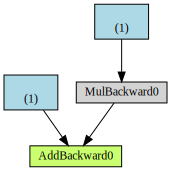

In [ ]:
make_dot(yhat)

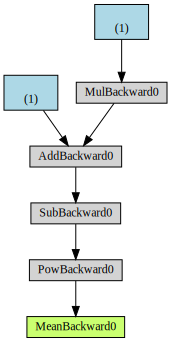

In [ ]:
make_dot(loss)

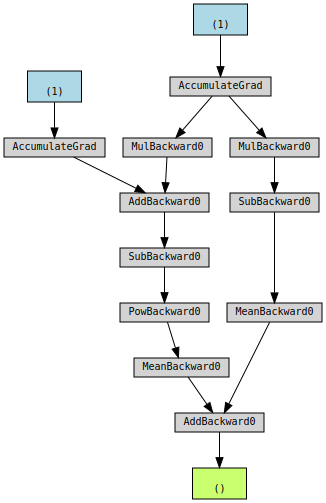

In [ ]:
# DAGs can be as complicated as you want, with multiple branches
#
# the following code does not make sense, except that it is syntactically correct and generates a DAG

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

if loss>0:
  yhat2 = b * x_train_tensor
  error2 = y_train_tensor - yhat2

loss += error2.mean()

make_dot(loss)

### **Actually, the optimizer can do the job for us**

PyTorch implements various optimizers, and we can use any of them.

In [ ]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()

    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()

    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()

print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


### **Wait, PyTorch can take care of the loss too**



In [ ]:

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor

    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)   # Here the loss function only requires the true outputs and the predicted outputs

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## **Pytorch: An entire model in a few lines (the most important part today)**

In PyTorch the Module class can be 'subclassed' to create models that inherit some general characteristics. The most important part is that we need
to define the **parameters** of the model and a **forward** function, that defines how the model evaluates its inputs.


In [ ]:
# This is how to create a new class for creating Linear Regression models.

class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

In [ ]:


torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)

# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):

    # This sets the model in 'training' mode. We have to use this.
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)

    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


The simple linear model we created is very basic. PyTorch offers (under nn) multiple pre-made functions that can be used in the DAG. Here is how to do this here:

In [ ]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        # this implicitly defines both a (the weight) and b (the intercept)
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

In [ ]:
[*LayerLinearRegression().parameters()]

[Parameter containing:
 tensor([[-0.2191]], requires_grad=True), Parameter containing:
 tensor([0.2018], requires_grad=True)]

### **Define a training function for better readability**

In [ ]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)

# Checks model's parameters
print(model.state_dict())

OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])
